In [17]:
#Import libraries
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchvision.models import efficientnet_b0
#from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
from PIL import Image

In [19]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [20]:
dir="C:\Survallaince_Project"
dir

'C:\\Survallaince_Project'

In [21]:
# Load the Data

# Set train and valid directory paths

dataset = "C:\Survallaince_Project"

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

2
{0: 'fire', 1: 'human'}


In [22]:
train_data_size, valid_data_size

(1282, 1305)

In [23]:
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [24]:
# Freeze model parameters
for param in efficientnet.parameters():
    param.requires_grad = False

# Change the final layer of EfficientNet Model for Transfer Learning
in_features = efficientnet._fc.in_features

new_fc_layers = nn.Sequential(
    nn.Linear(in_features, num_classes),
    nn.LogSoftmax(dim=1)
)

efficientnet._fc = new_fc_layers


In [25]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(efficientnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [26]:
def train_and_validate(model, loss_criterion, optimizer, epochs=5):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'model'+str(epoch)+'.pt')
            
    return model, history

In [27]:
os.makedirs(dataset, exist_ok=True)

# Save the training history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 100
trained_model, history = train_and_validate(efficientnet, loss_func, optimizer, num_epochs)

torch.save(history, os.path.join(dataset, '_history.pt'))

Epoch: 1/100
Epoch : 001, Training: Loss: 0.3436, Accuracy: 88.1435%, 
		Validation : Loss : 0.1681, Accuracy: 95.4789%, Time: 188.8245s
Epoch: 2/100
Epoch : 002, Training: Loss: 0.1437, Accuracy: 96.4119%, 
		Validation : Loss : 0.0831, Accuracy: 98.6973%, Time: 189.1436s
Epoch: 3/100
Epoch : 003, Training: Loss: 0.1026, Accuracy: 97.2699%, 
		Validation : Loss : 0.0647, Accuracy: 98.7739%, Time: 190.6249s
Epoch: 4/100
Epoch : 004, Training: Loss: 0.0894, Accuracy: 97.9719%, 
		Validation : Loss : 0.0583, Accuracy: 99.0038%, Time: 189.0713s
Epoch: 5/100
Epoch : 005, Training: Loss: 0.0712, Accuracy: 98.1279%, 
		Validation : Loss : 0.0517, Accuracy: 99.3103%, Time: 190.2546s
Epoch: 6/100
Epoch : 006, Training: Loss: 0.0750, Accuracy: 97.8159%, 
		Validation : Loss : 0.0511, Accuracy: 99.0805%, Time: 189.9736s
Epoch: 7/100
Epoch : 007, Training: Loss: 0.0755, Accuracy: 97.7379%, 
		Validation : Loss : 0.0471, Accuracy: 99.0038%, Time: 187.2887s
Epoch: 8/100
Epoch : 008, Training: Loss:

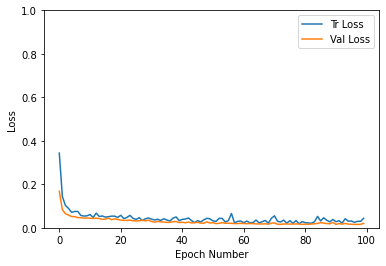

In [28]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
spath='C:\\Users\\ksjav\\Downloads\\'
plt.savefig( spath + '_loss_curve.png')
plt.show()

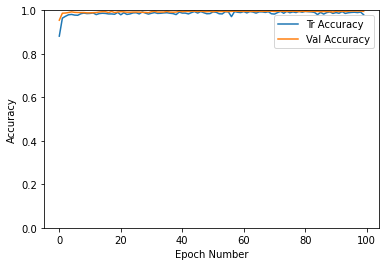

In [29]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(spath+'_accuracy_curve.png')
plt.show()

In [30]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(2):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

Predcition 1 : human , Score:  0.9991917
Predcition 2 : fire , Score:  0.0008082703


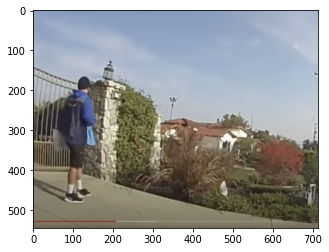

In [64]:
predict(trained_model,"C:\\Survallaince_Project\\valid\\human\\116.png")

Predcition 1 : fire , Score:  0.9909862
Predcition 2 : human , Score:  0.009013837


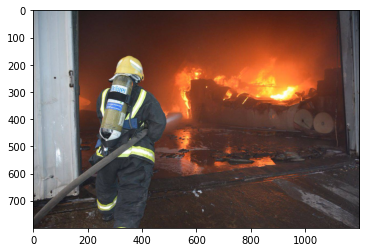

In [63]:
predict(trained_model,"C:\\Survallaince_Project\\valid\\fire\\fire.120.png")